In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MaxAbsScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline

!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [0]:
trainX_df = pd.read_csv('data/trainX.csv')
trainY_df = pd.read_csv('data/trainY.csv')
testX_df = pd.read_csv('data/testX.csv')
sub = pd.read_csv('data/sampleSubmission.csv')


In [0]:
trainX = trainX_df.drop('Id', axis=1)
testX = testX_df.drop('Id', axis=1)
trainY = trainY_df.Value.values

In [0]:
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, shuffle=False)

**Обучаем на простых данных**

Параметры подобраны grid search





In [0]:
cat_params = {'depth': 5, 'l2_leaf_reg': 6.0, 'learning_rate': 0.1, 'n_estimators': 1000, 'silent': True}

In [0]:
cbr = CatBoostRegressor(**cat_params)
cbr.fit(X_train, y_train)

pred = cbr.predict(X_val)
print('r2 on val ', r2_score(pred, y_val))
print('score on val ', cbr.score(X_val, y_val))

r2 on val  0.4352503840118128
score on val  0.6510874473537018


Посмотрим на данные

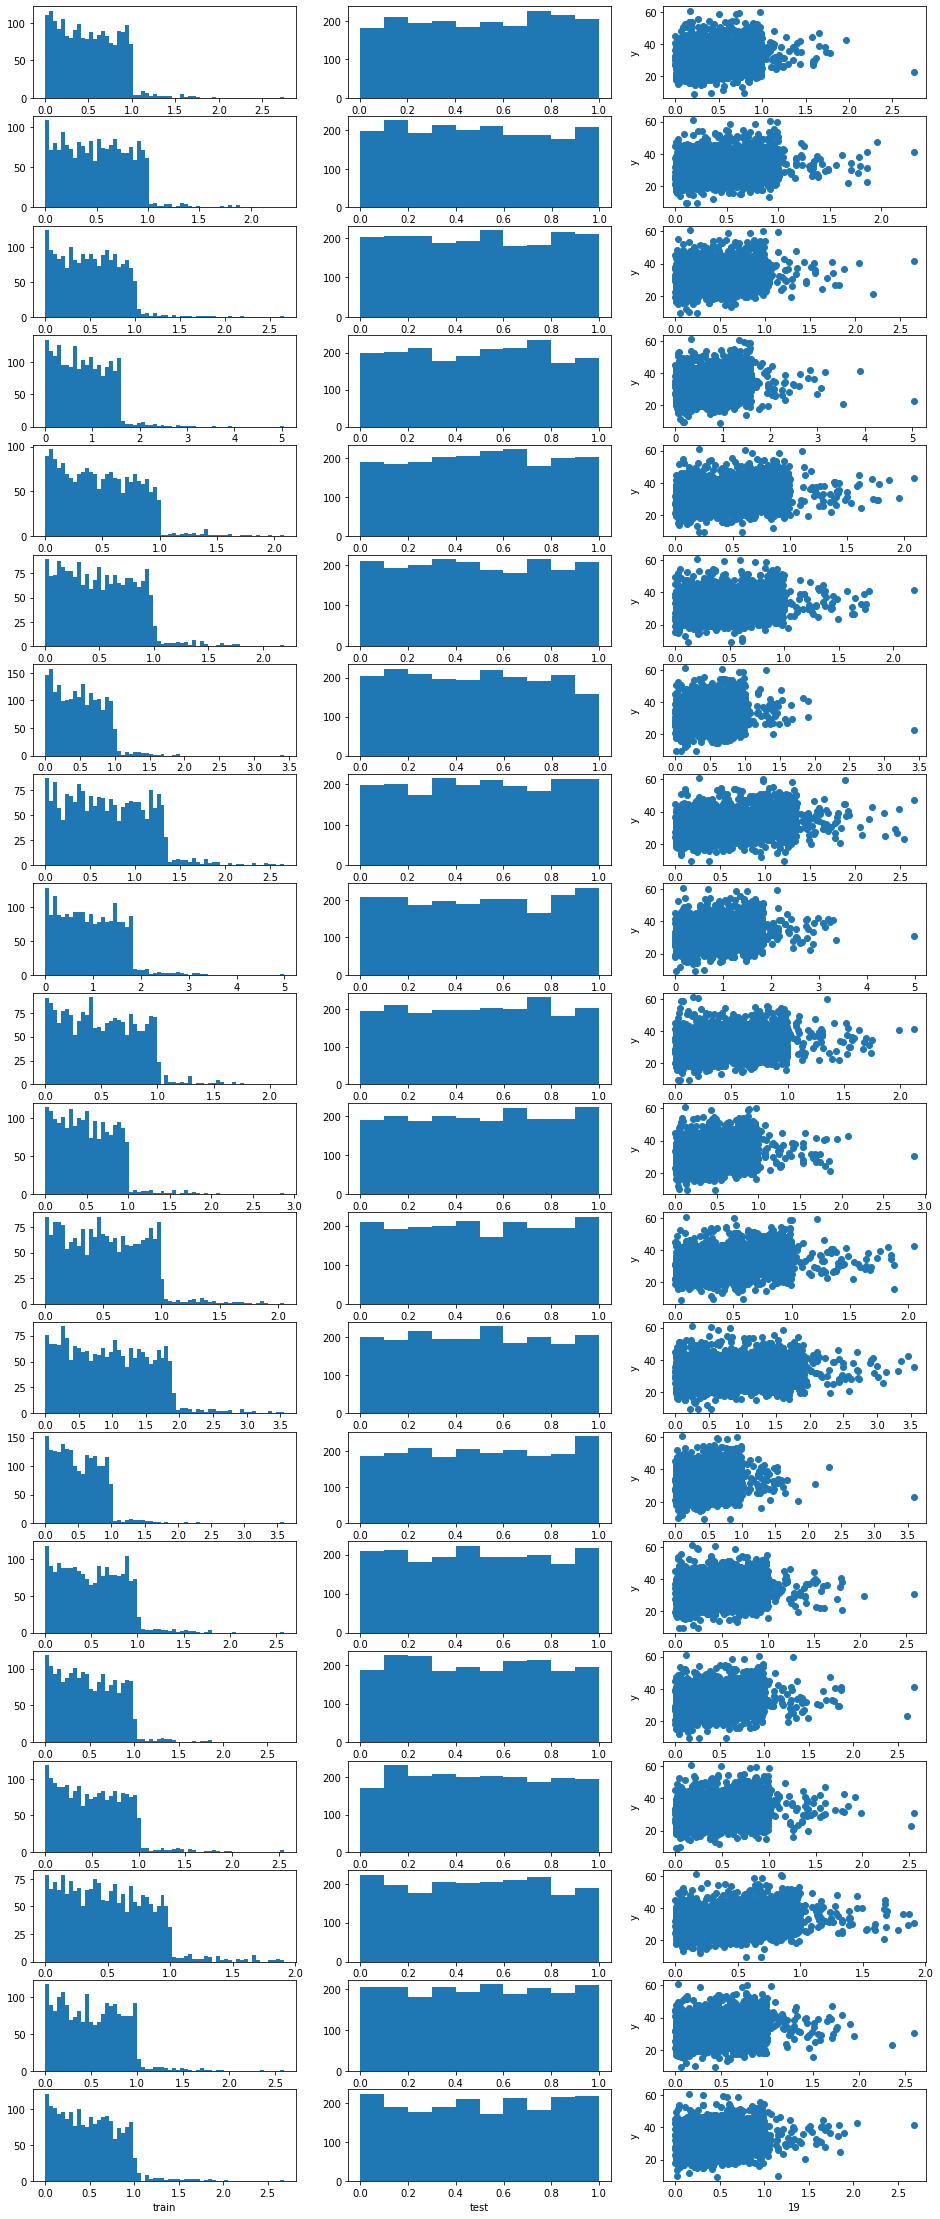

In [0]:
# plt.figure(figsize=(16,55))
fig, axs = plt.subplots(trainX_df.shape[1]-1, 3,figsize=(16,40))
for i, col in enumerate(trainX_df.columns[:-1]):
  axs[i, 2].scatter(trainX_df[col], trainY_df.Value)
  axs[i, 2].set(xlabel=col, ylabel='y')
  axs[i, 0].hist(trainX_df[col], bins=60)
  axs[i, 0].set(xlabel='train')
  axs[i, 1].hist(testX_df[col])
  axs[i, 1].set(xlabel='test')
  
plt.show()

  


видим, что на некоторых объектах в обучении признаки больше 1, но в тесте все меньше 1. выбросим предположительные выбросы

In [0]:
thresholds = [1] * (trainX_df.shape[1] - 1)
thresholds[3] = 1.7
thresholds[7] = 1.6
thresholds[8] = 2
thresholds[12] = 2

outliers = []

for i, col in enumerate(trainX_df.columns[:-1]):
    outliers += list(np.where(trainX_df[col] > thresholds[i])[0])
    
trainX_cleaned = trainX_df.drop(list(np.unique(outliers)), axis=0)
trainY_cleaned = trainY_df.drop(list(np.unique(outliers)), axis=0)

cleanedX = trainX_cleaned.drop(['Id'], axis=1).values
cleanedY = trainY_cleaned.Value.values

X_train_cleaned, X_val_cleaned, y_train_cleaned, y_val_cleaned = train_test_split(cleanedX, cleanedY, shuffle=False)

In [0]:
cbr = CatBoostRegressor(**cat_params)
cbr.fit(X_train_cleaned, y_train_cleaned)

pred = cbr.predict(X_val_cleaned)
print('r2 on val ', r2_score(pred, y_val_cleaned))
print('score on val ', cbr.score(X_val_cleaned, y_val_cleaned))

r2 on val  0.5291391420966014
score on val  0.7115522631877546


**Обучим несколько бустингов с мета моделью**

In [0]:
#2000
cat_params = {'depth': 5, 'l2_leaf_reg': 9, 'learning_rate': 0.01, 'n_estimators': 2000, 'silent': True}

In [0]:
rgrsrs = [
    ('cbr1', CatBoostRegressor(**cat_params)),
    ('cbr2', CatBoostRegressor(**cat_params)),
    ('cbr3', CatBoostRegressor(**cat_params)),
    ('cbr4', CatBoostRegressor(**cat_params)),
]
st = StackingRegressor(estimators=rgrsrs, final_estimator=Ridge(), n_jobs=-1)
st.fit(X_train_cleaned, y_train_cleaned)

y_pred = st.predict(X_val_cleaned)
print('MSE on val: ', mean_squared_error(y_pred, y_val_cleaned))
print('R2 on val:  ', r2_score(y_pred, y_val_cleaned))
print('score on val', st.score(X_val_cleaned, y_val_cleaned))

MSE on val:  16.483626933528573
R2 on val:   0.6343867526838003
score on val 0.7099965141806259


Делаем предсказание 

In [0]:
st = StackingRegressor(estimators=rgrsrs, final_estimator=Ridge(), n_jobs=-1)
st.fit(cleanedX, cleanedY)

y_pred = st.predict(testX)

KeyboardInterrupt: ignored

In [0]:
submission = sub.copy()
submission.Value = y_pred
submission.to_csv('submission.csv', index=False)
submission.head(10)